In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy.sparse.linalg as sla

# Rectangular simplistic model

In [2]:
# I will start with recatngular dot
dot = kwant.Builder()
lat = kwant.lattice.square(a=1., norbs=1)
# alat, blat = lat.sublattices

def onsite(site, mu, imp, U_imp):
    return mu + U_imp*(-0.5 + kwant.digest.uniform(repr(site), repr(imp)))

def peierls_sub(site1, site2, B):
    x0, y0 = site1.pos
    x1, y1 = site2.pos
    # m, b = (x1 - x0)/(y1 - y0), x0 - y0*(x1 - x0)/(y1 - y0)
    # phi = B*(y1 + y0)*(x1 - x0)/2 + B*x0*(y1- y0) - B*y0*(x1 - x0)
    # phi = B*(y1 + y0)*(x1 - x0)/2 + B*(x0*y1 -y0*x1)
    phi = B*(y1 + y0)*(x1 - x0)/2
    return -np.exp(-1j*phi)

h, w = 30, 50
def rect(pos):
    return 0<=pos[0] < w and -1/2<=pos[1] < h-1/2

dot[lat.shape(rect, (0, 0))] = onsite
dot[lat.neighbors()]=peierls_sub

# remove bad atoms
sites = list(dot.sites())
# Count the number of connections (hopping terms) for the site
for s in sites:
    num_connections = sum(1 for _ in dot.neighbors(s))
    if num_connections == 1: del dot[s]

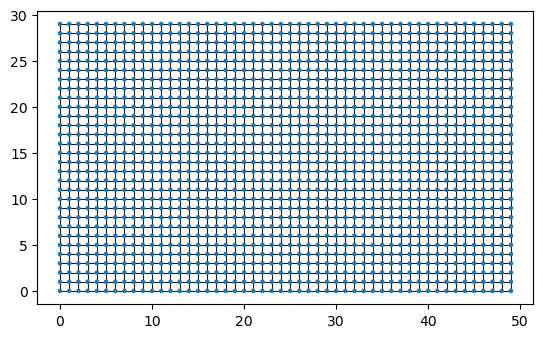

In [3]:
kwant.plot(dot)
plt.show()

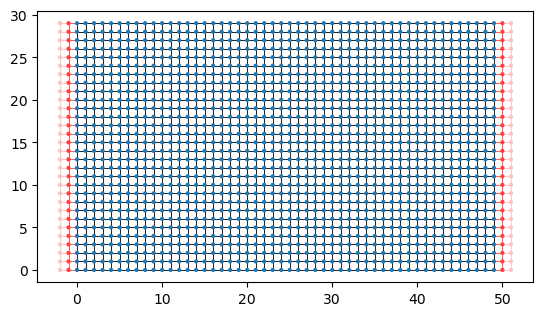

In [4]:
# attach leads:
lead = kwant.Builder(kwant.TranslationalSymmetry(lat.vec([-1, 0])))
lead[lat.shape(lambda pos: -1/2 < pos[1] < h - 0.5 , (10, 1))] = 4.0
lead[lat.neighbors()] = peierls_sub

dot.attach_lead(lead)
dot.attach_lead(lead.reversed())

kwant.plot(dot)
plt.show()

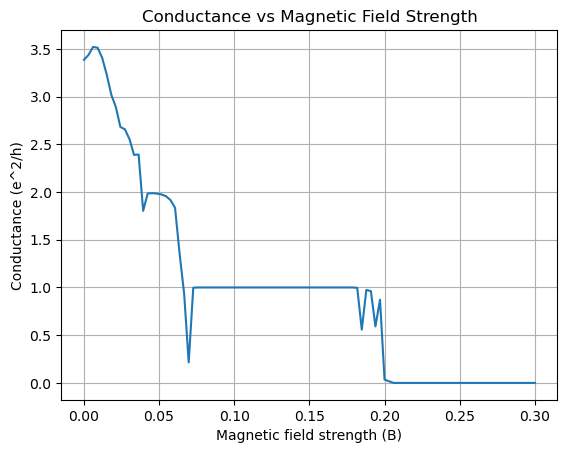

In [35]:
# Finalize the system
finalized_dot = dot.finalized()

# Define the energy at which to calculate the conductance
U0 = 0.3
salt = 0.0
energy = 0.2

B_values = np.linspace(0, .3, 100)
conductances = []

for B in B_values:
    smatrix = kwant.smatrix(finalized_dot, energy, params=dict(B=B, imp=salt, mu=4.0, U_imp = U0))
    conductance = smatrix.transmission(0, 1)
    conductances.append(conductance)

plt.plot(B_values, conductances)
plt.xlabel('Magnetic field strength (B)')
plt.ylabel('Conductance (e^2/h)')
plt.title('Conductance vs Magnetic Field Strength')
plt.grid(True)
plt.show()

In [17]:
finalized_dot.leads[0]

/tmp/ipykernel_78985/3456432747.py:4: RuntimeWarning:

The plotted data contains 1.07% of values overflowing upper limit 0.306119 



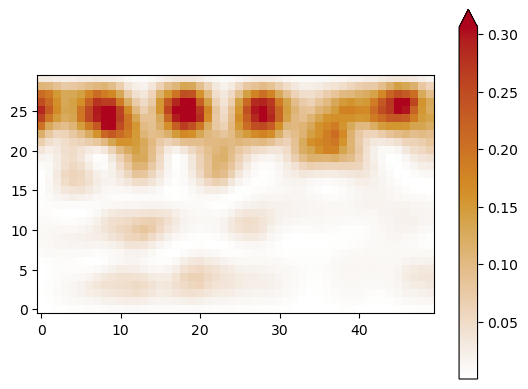

In [31]:
params=dict(B=0.02, imp=salt, mu=4.0, U_imp = U0)
psi = kwant.wave_function(finalized_dot, energy, params=params)
psi = psi(0)
kwant.plotter.map(finalized_dot, abs(psi[0])**2)
plt.show()

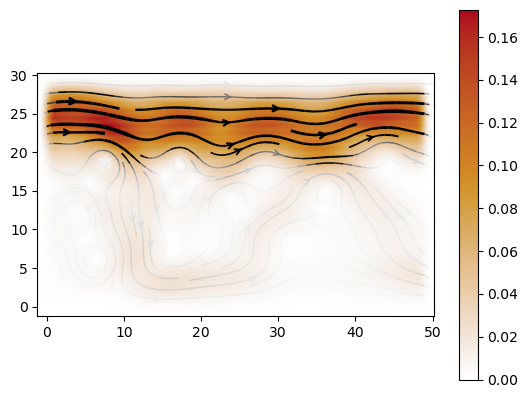

In [32]:
current_op = kwant.operator.Current(finalized_dot)
current = current_op(psi[0], params=params)
kwant.plotter.current(finalized_dot, current)
plt.show()

# Graphene stuff

In [2]:
graphene = kwant.lattice.honeycomb(a = 1.0, norbs=1)
a, b = graphene.sublattices

In [3]:
bulk = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
bulk[graphene.shape(lambda pos: True, (0, 0))] = 0
bulk[graphene.neighbors()] = 1.0

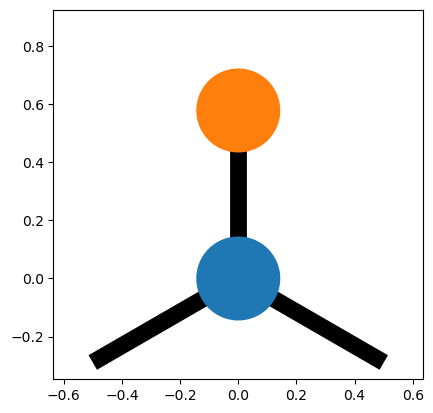

In [4]:
kwant.plot(bulk)
plt.show()

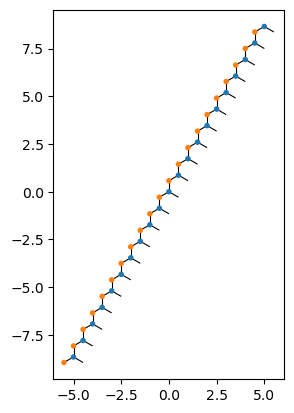

In [5]:
rib_zz = kwant.Builder(kwant.TranslationalSymmetry([1, 0]))
rib_zz[a.shape((lambda pos: abs(pos[1]) < 9), (0, 0))] = +0
rib_zz[b.shape((lambda pos: abs(pos[1]) < 9), (0, 0))] = -0
rib_zz[graphene.neighbors()] = 1.0
kwant.plot(rib_zz)
plt.show()

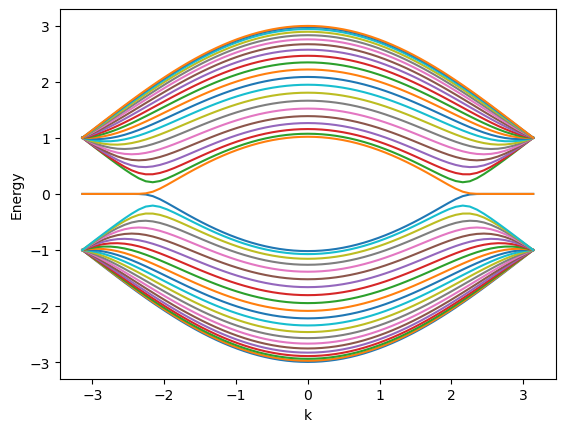

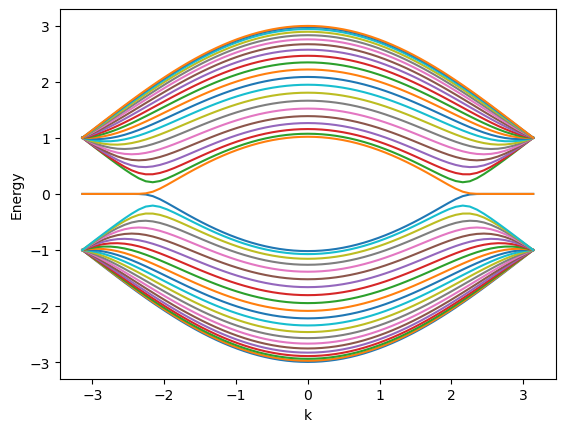

In [6]:
kwant.plotter.bands(rib_zz.finalized())

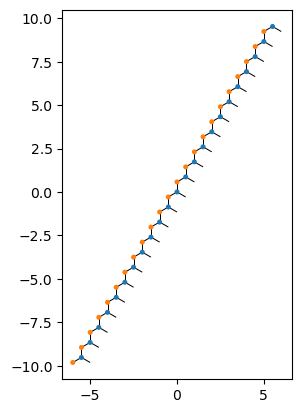

In [11]:
zigzag_ribbon = kwant.Builder(kwant.TranslationalSymmetry(graphene.vec((1, 0))))
zigzag_ribbon[a.shape((lambda pos: abs(pos[1]) < 10), (0, 0))] = 0
zigzag_ribbon[b.shape((lambda pos: abs(pos[1]) < 10), (0, 0))] = 0
zigzag_ribbon[graphene.neighbors()] = 1.0

kwant.plot(zigzag_ribbon)
plt.show()

# nnn(next nearest neighbor) interaction

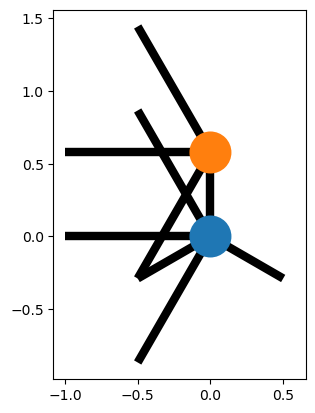

In [ ]:
nnn_hop = lambda site1, site2, t2: 1j*t2
nn_hop = 1  # reference
onsite = lambda site, mu: mu

rib_zz2 = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
rib_zz2[graphene.shape((lambda pos: True), (0, 0))] = onsite
rib_zz2[graphene.neighbors(1)] = 1.0
rib_zz2[graphene.neighbors(2)] = nnn_hop

kwant.plot(rib_zz2)
plt.show()